In [14]:
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa.display

In [15]:
processed_dir = '../data/processed'
feature_output_dir = '../data/features/mel'
unknown_dir = os.path.join(processed_dir, 'unknown')

In [16]:
def extract_mel_spectrogram(audio_path, n_mels=128, n_fft=2048, hop_length=128):
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)
    
    # Extract mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length,
        fmin=20,
        fmax=sr/2,
        power=2.0
    )
    
    # Convert to log scale (dB)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Normalize to [0, 1]
    mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
    
    # Resize to (128, 32)
    mel_spec_norm = tf.image.resize(mel_spec_norm[..., np.newaxis], (128, 32))
    mel_spec_norm = mel_spec_norm.numpy()
    mel_spec_norm = mel_spec_norm[..., 0]
    
    return mel_spec_norm

In [17]:
audio_files = []
for fname in os.listdir(unknown_dir):
    if fname.endswith('.wav'):
        audio_files.append(os.path.join(unknown_dir, fname))

metadata = []

for audio_path in tqdm(audio_files, desc='Extracting Mel spectrograms for unknown'):
    rel_path = os.path.relpath(audio_path, processed_dir)
    feature_dir = os.path.join(feature_output_dir, os.path.dirname(rel_path))
    os.makedirs(feature_dir, exist_ok=True)

    # Extract mel spectrogram
    mel_features = extract_mel_spectrogram(audio_path)

    # Save .npy file
    feature_path = os.path.join(feature_dir, os.path.splitext(os.path.basename(audio_path))[0] + '.npy')
    np.save(feature_path, mel_features)

    # Add to metadata
    metadata.append({
        'audio_path': rel_path,
        'feature_path': os.path.relpath(feature_path, feature_output_dir),
        'mel_shape': mel_features.shape,
        'duration': librosa.get_duration(path=audio_path),
        'sr': librosa.get_samplerate(audio_path)
    })

Extracting Mel spectrograms for unknown: 100%|██████████| 150/150 [00:01<00:00, 118.88it/s]


In [18]:
metadata_df = pd.DataFrame(metadata)
existing_metadata = pd.read_csv(os.path.join(feature_output_dir, 'metadata.csv'))
combined_metadata = pd.concat([existing_metadata, metadata_df], ignore_index=True)
combined_metadata.to_csv(os.path.join(feature_output_dir, 'metadata.csv'), index=False)

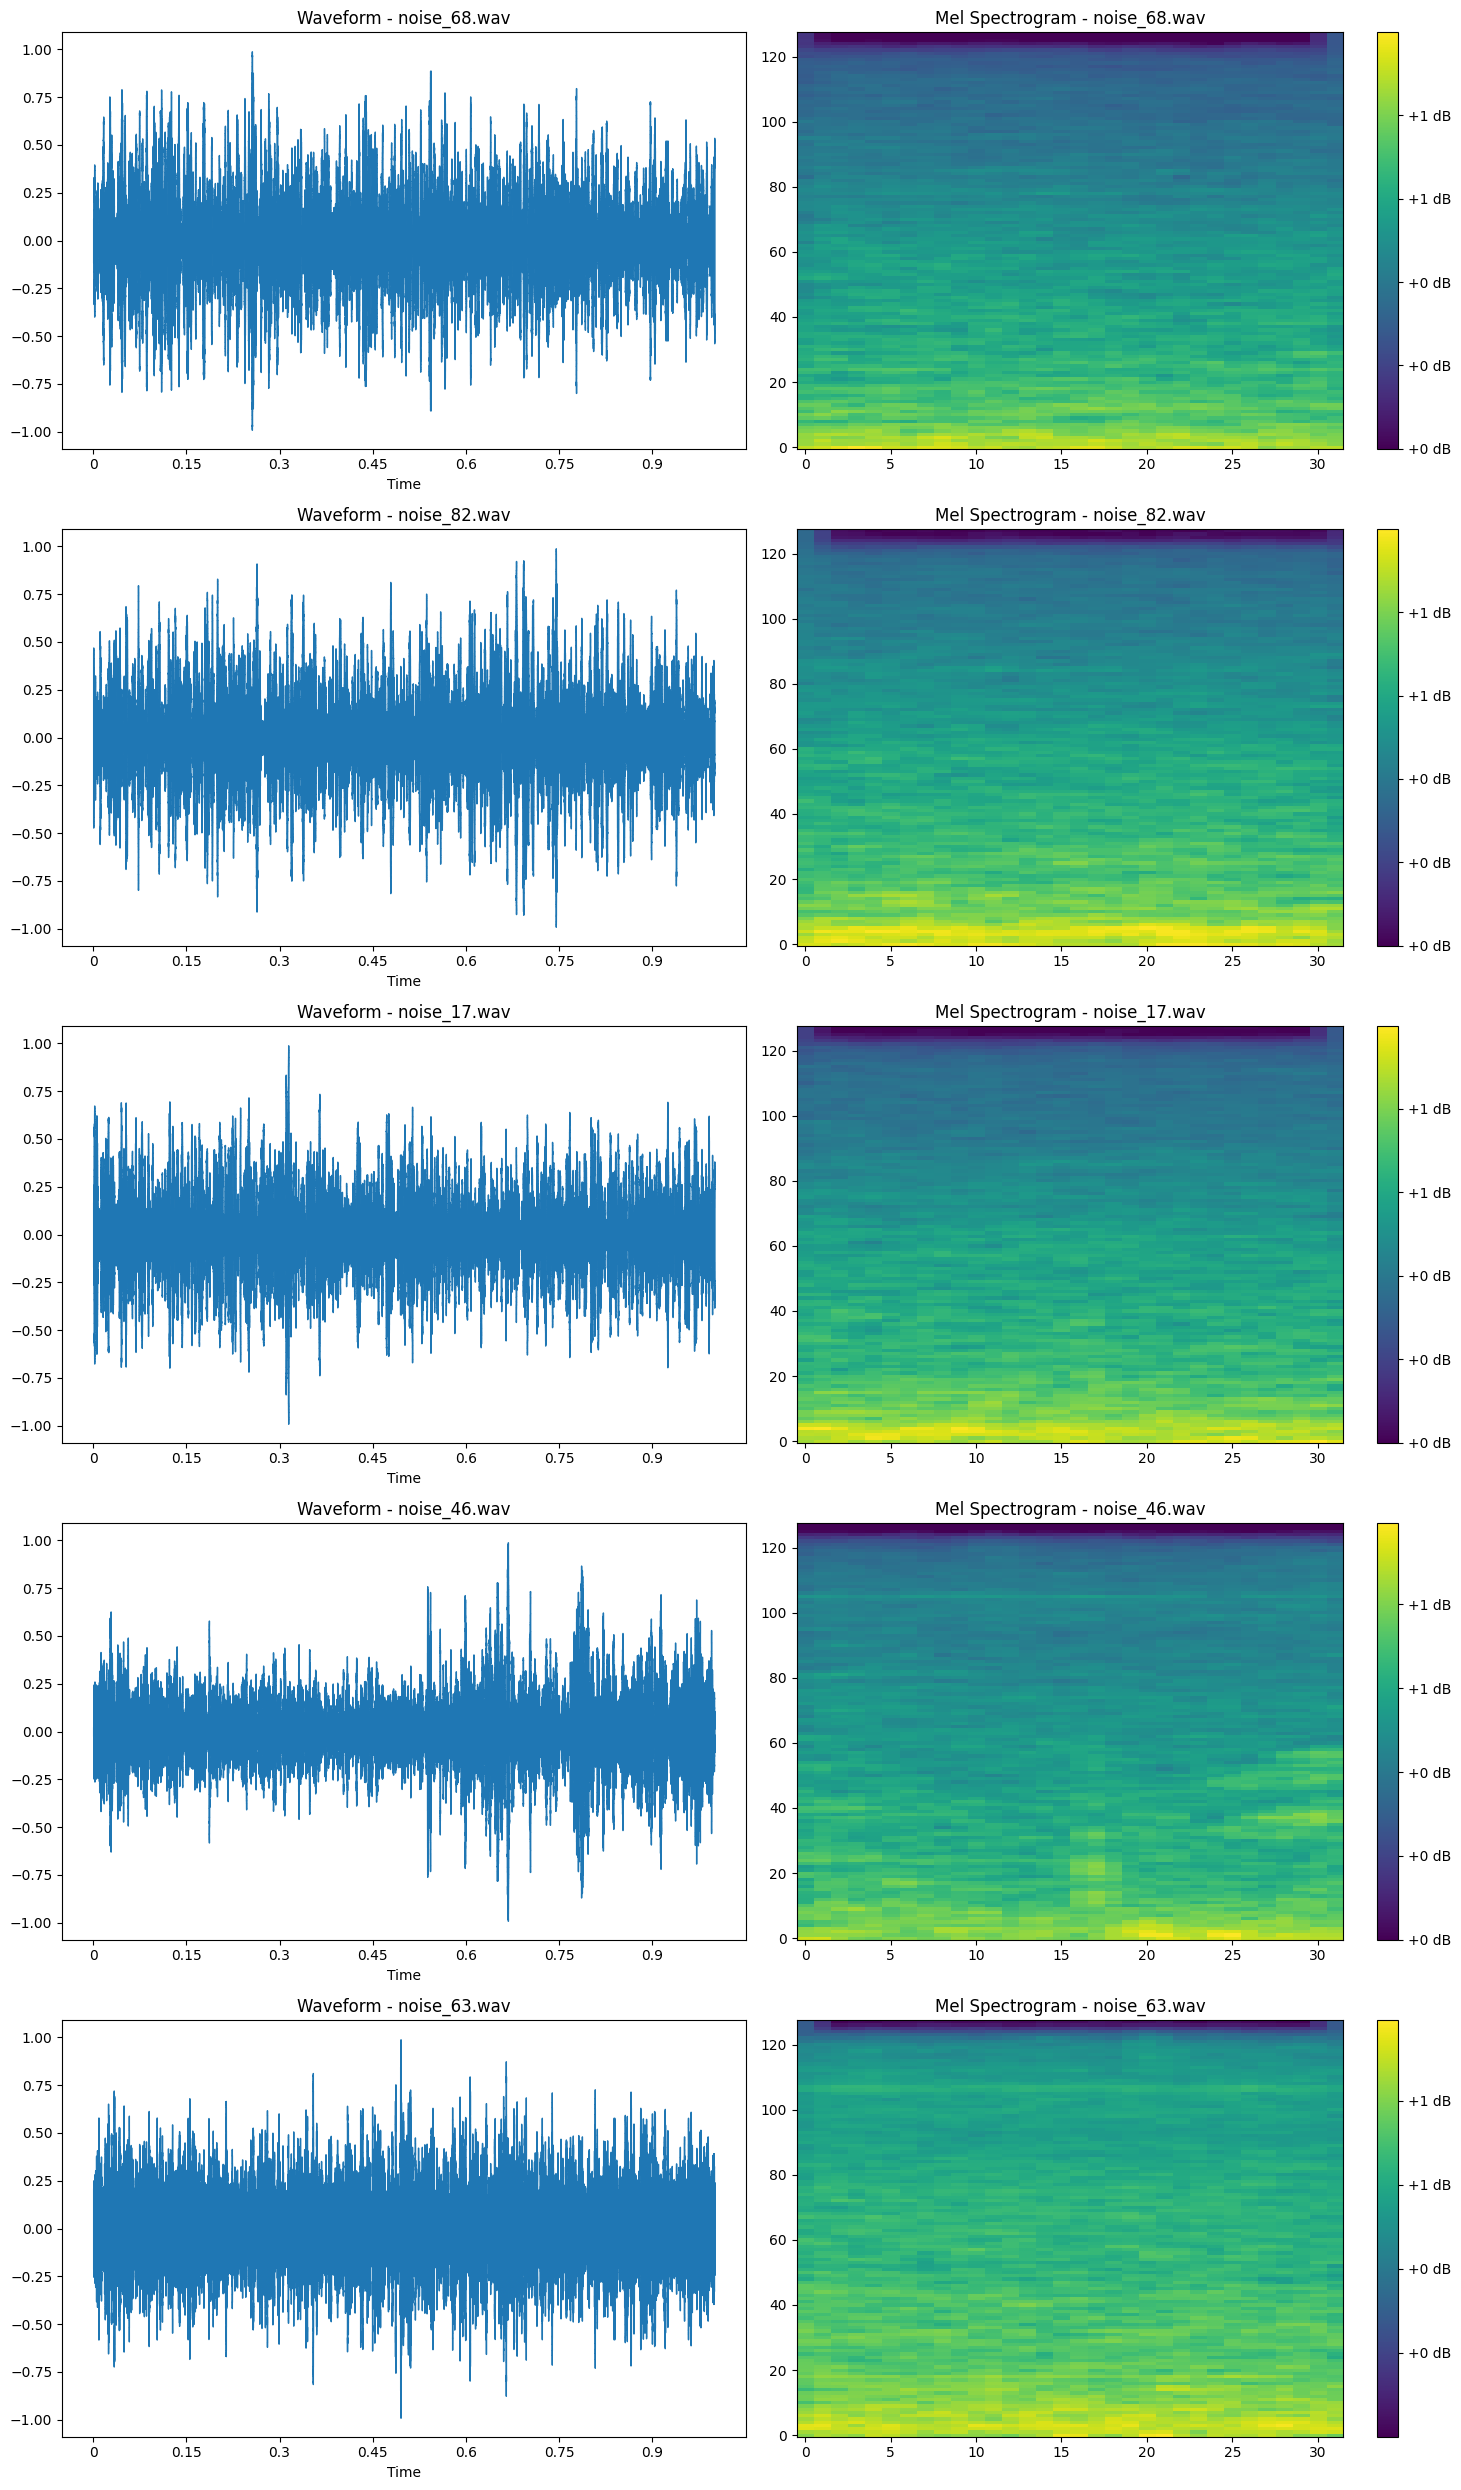


Feature Statistics:
Total number of processed files: 150
Mel spectrogram shape: (128, 32)
Value range: [0.000, 0.992]
Mean value: 0.639
Standard deviation: 0.142


In [20]:
# Select a few random examples to visualize
sample_size = 5
sample_files = np.random.choice(audio_files, size=sample_size, replace=False)

plt.figure(figsize=(15, 5*sample_size))
for idx, audio_path in enumerate(sample_files):
    # Load and plot original waveform
    plt.subplot(sample_size, 2, 2*idx + 1)
    y, sr = librosa.load(audio_path, sr=None)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform - {os.path.basename(audio_path)}')
    
    # Load and plot mel spectrogram
    plt.subplot(sample_size, 2, 2*idx + 2)
    mel_features = np.load(os.path.join(feature_output_dir, 'unknown', 
                                      os.path.splitext(os.path.basename(audio_path))[0] + '.npy'))
    plt.imshow(mel_features, aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram - {os.path.basename(audio_path)}')

plt.tight_layout()
plt.show()

# Print some statistics about the extracted features
print("\nFeature Statistics:")
print(f"Total number of processed files: {len(audio_files)}")
print(f"Mel spectrogram shape: {mel_features.shape}")
print(f"Value range: [{mel_features.min():.3f}, {mel_features.max():.3f}]")
print(f"Mean value: {mel_features.mean():.3f}")
print(f"Standard deviation: {mel_features.std():.3f}")